## Notebook Imports

In [130]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

%matplotlib inline

# for installing a package
# conda install -c channel_name package name

## Constants

In [174]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

WORD_ID_FILE ='SpamData/01_Processing/word-by-id.csv'
DATA_JSON_FILE ='SpamData/01_Processing/email-text-data.json'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/03_Testing/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
FONT_BOLD = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'
FONT_LIGHT = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Light.ttf'




## Reading Files

In [3]:
stream = open(EXAMPLE_FILE,encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)



<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE_FILE,encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body=True


stream.close()

email_body = ' '.join(lines)
print(email_body)
# print(lines)



 Dear Mr Still
 
 Good tidings to you and all your staff for the festive season ahead (Christmas).
 Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.
 But WAIT! You're probably thinking: "What makes him so special?"
 Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.
 You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.
 I look forward to hearing from you.
 
 Best wishes
 Robin Cooper
 [Excerpt from the book: The Timewaster Let

## Generator Functions

In [6]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number**2
        

In [7]:
for i in generate_squares(5):
    print(i,end=' ->')

0 ->1 ->4 ->9 ->16 ->

## Email Body Extraction

In [8]:
def email_body_generator(path):

    for root, dirnames, filenames in walk(path):
        for file_name in filenames:

            filepath = join(root,file_name)
            stream = open(filepath,encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body=True


            stream.close()

            email_body = ' '.join(lines)
            yield file_name,email_body      

In [9]:
def df_from_directory(path,classification):
    rows = []
    row_names = []

    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body,'CATEGORY':classification})
        row_names.append(file_name)
    return pd.DataFrame(rows,index=row_names)

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH,SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH,SPAM_CAT))


In [11]:
spam_emails.shape

(1898, 2)

In [12]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH,HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))
ham_emails.shape

(3901, 2)

In [13]:
data = pd.concat([spam_emails,ham_emails])
print('Shape of entire dataframe is',data.shape)
data.head()

Shape of entire dataframe is (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n http://www.adcl...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n http://www.adcl...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n 1) Slim Down...,1


In [14]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n \n Now this is probably of no use ...",0


## Data Cleaning: Checking for Missing values

In [15]:
# check if any messages are null
data['MESSAGE'].isnull().values.any()

False

In [16]:
type('')

str

In [17]:
len('')

0

In [18]:
my_var = None # null in py

In [19]:
type(my_var)

NoneType

In [20]:
# check if there are empty strings
(data['MESSAGE'].str.len() == 0).any()

True

In [21]:
(data['MESSAGE'].str.len() == 0).sum()


3

In [22]:
#Challenge number of entries of null
data['MESSAGE'].isnull().sum()

0

### Locate empty emails

In [23]:
data[data['MESSAGE'].str.len()==0 ].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [24]:
data.index.get_loc('cmds').any()

True

In [25]:
data.drop(['cmds'],inplace=True)

In [26]:
data.shape

(5796, 2)

## Add Document IDs to Track Emails in Dataset

In [27]:
document_ids = range(0,len(data.index))
data['DOC_ID']=document_ids

In [28]:
data.DOC_ID

00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    5792
01398.169b51731fe569f42169ae8f948ec676    5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    5794
01400.f897f0931e461e7b2e964d28e927c35e    5795
Name: DOC_ID, Length: 5796, dtype: int32

In [29]:
data['FILE_NAME']=data.index
data.set_index('DOC_ID',inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n http://www.adcl...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n http://www.adcl...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n 1) Slim Down...,1,00005.57696a39d7d84318ce497886896bf90d


In [30]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n \n Now this is probably of no use ...",0,01400.f897f0931e461e7b2e964d28e927c35e


## Save to File Using Pandas

In [31]:
data.to_json(DATA_JSON_FILE)

## Number of Spam Messages Visualised (Pie Charts)

In [32]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [33]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

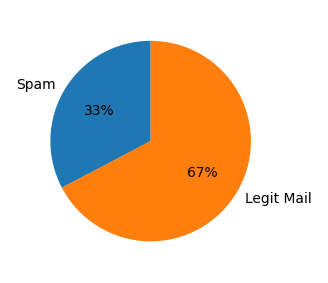

In [34]:
category_names = ['Spam','Legit Mail']
sizes = [amount_of_spam,amount_of_ham]

plt.figure(figsize=(2,2),dpi=166)
plt.pie(sizes,labels=category_names,textprops={"fontsize":6},startangle=90,autopct='%1.0f%%')
plt.show()

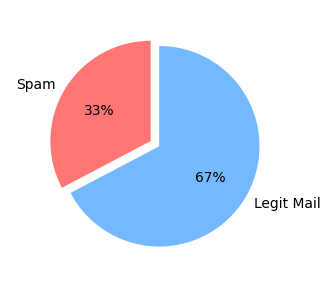

In [35]:
category_names = ['Spam','Legit Mail']
sizes = [amount_of_spam,amount_of_ham]
custom_colors =['#ff7675','#74b9ff']

plt.figure(figsize=(2,2),dpi=166)
plt.pie(sizes,labels=category_names,textprops={"fontsize":6},startangle=90,autopct='%1.0f%%',colors=custom_colors,explode=[0,0.1])
plt.show()

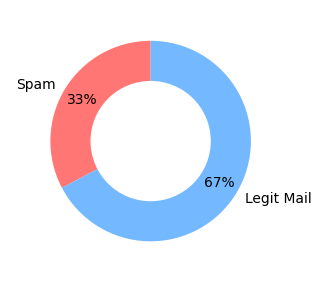

In [36]:
category_names = ['Spam','Legit Mail']
sizes = [amount_of_spam,amount_of_ham]
custom_colors =['#ff7675','#74b9ff']

plt.figure(figsize=(2,2),dpi=166)
plt.pie(sizes,labels=category_names,textprops={"fontsize":6},startangle=90,autopct='%1.0f%%',colors=custom_colors,pctdistance=0.8)

#draw circle
centre_circle = plt.Circle((0,0),radius=0.6,fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

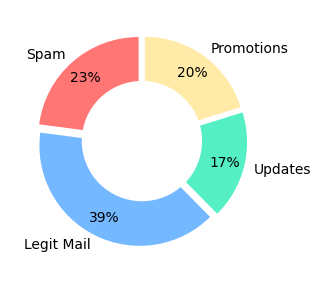

In [37]:
category_names = ['Spam','Legit Mail','Updates','Promotions']
sizes = [25,43,19,22]
custom_colors =['#ff7675','#74b9ff','#55efc4','#ffeaa7']
offset=[0.05,0.05,0.05,0.05]
plt.figure(figsize=(2,2),dpi=166)
plt.pie(sizes,labels=category_names,textprops={"fontsize":6},startangle=90,autopct='%1.0f%%',colors=custom_colors,pctdistance=0.8,explode=offset)

#draw circle
centre_circle = plt.Circle((0,0),radius=0.6,fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

## Text Pre-Processing

In [38]:
msg = 'All work an no play makes Jack a dull boy.'
msg.lower()

'all work an no play makes jack a dull boy.'

### Download the NLTK Resources (Tokenizer & StopWords)

In [39]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BHANU\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [40]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BHANU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\BHANU\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\BHANU\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

### Tokenising

In [42]:
msg = 'All work an no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'an', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

### Removing stop words

In [43]:
stop_words = set(stopwords.words('english'))

In [44]:
type(stop_words)

set

In [45]:
if 'this' in stop_words:
    print('found it')

found it


In [46]:
if 'hello' not in stop_words:
    print('Nope not in here')

Nope not in here


In [47]:
#Challenge: append non-stop words to filtered_words
msg = 'All work an no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())
filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


### Word Stems and Stemming

In [48]:
msg = 'All work an no play makes Jack a dull boy. To be or not to be. \
    Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word=stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


### Removing punctuation

In [49]:
msg = 'All work an no play makes Jack a dull boy. To be or not to be. ??? \
    Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())


stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha() :
        stemmed_word=stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


### Removing HTML tags from Emails

In [50]:
soup = BeautifulSoup(data.at[0,'MESSAGE'],'html.parser')
print(soup.prettify())


<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<html>
 <head>
  <meta charset="utf-8" content='3D"text/html;' http-equiv="3DContent-T=" ype=""/>
  <meta 5.00.2314.1000"="" content='3D"MSHTML' name="3DGENERATOR"/>
 </head>
 <body>
  <!-- Inserted by Calypso -->
  <table black;="" border="3D0" cellpadding="3D0" cellspacing="3D2" display:="" id="3D_CalyPrintHeader_" none"="" r="ules=3Dnone" style='3D"COLOR:' width='3D"100%"'>
   <tbody>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
   </tbody>
  </table>
 </body>
</html>
<tr>
 <td colspan="3D3">
  <hr color="3Dblack" noshade="" size="3D1"/>
 </td>
</tr>
<!-- End Calypso -->
<!-- Inserted by Calypso=
  -->
<font color="3D#000000" face="3DVERDANA,ARIAL,HELVETICA" size="3D-2">
 <br/>
</font>
&lt;=
 /TR&gt;
<!-- End Calypso -->
<font bold"="" color="3D#ff0000" face='3D"Copperplate' gothic="" ptsize='3D"10"' size="3D5">
 <center>
  Save up to 70% on Life Insurance.
 </ce

In [51]:
soup.get_text()

"\n\n\n\n\n\n\n\n\n\n\n\n\n\n<=\n /TR>\nSave up to 70% on Life Insurance.\nWhy Spend More Than You Have To?\n \nLife Quote Savings\n \n\n\n\n\n\n\n\n\n\nEnsurin=\n g your \n       family's financial security is very important. Life Quote Savings ma=\n kes \n       buying life insurance simple and affordable. We Provide FREE Access =\n to The \n       Very Best Companies and The Lowest Rates.\n\n\n\n\n\nLife Quote Savings is FAST, EAS=\n Y and \n             SAVES you money! Let us help you get started with the best val=\n ues in \n             the country on new coverage. You can SAVE hundreds or even tho=\n usands \n             of dollars by requesting a FREE quote from Lifequote Savings. =\n Our \n             service will take you less than 5 minutes to complete. Shop an=\n d \n             compare. SAVE up to 70% on all types of Life insurance! \n \n\n\nClick Here For Your=\n  \n             Free Quote!\n\nProtecting your family is the best investment you'll eve=\n r \n           

## Functions for Email Processing

In [52]:
def clean_message(message,stemmer= PorterStemmer(),stop_words=set(stopwords.words('english'))):
    
    # Converts to Lowercase and splits up the words
    words = word_tokenize( message.lower())
    filtered_words = []

    for word in words:
        # Removes stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))

    return filtered_words

In [53]:
clean_message(email_body)


['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [54]:
def clean_msg_no_html(message,stemmer= PorterStemmer(),stop_words=set(stopwords.words('english'))):
    
    # Remove html tags
    soup= BeautifulSoup(message,'html.parser')
    strings = soup.get_text()

    # Converts to Lowercase and splits up the words
    words = word_tokenize( strings.lower())
    filtered_words = []

    for word in words:
        # Removes stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))

    return filtered_words

In [55]:
clean_msg_no_html(data.at[0,'MESSAGE'])

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email']

# Apply Cleaning and Tokenization to all messages

### Slicing Dataframes and Series & Creating subsets

In [56]:
data.iat[3,0]

"##################################################\n #                                                #\n #                 Adult Club                     #\n #           Offers FREE Membership               #\n #                                                #\n ##################################################\n \n >>>>>  INSTANT ACCESS TO ALL SITES NOW\n >>>>>  Your User Name And Password is.\n >>>>>  User Name: zzzz@spamassassin.taint.org\n >>>>>  Password: 760382\n \n 5 of the Best Adult Sites on the Internet for FREE!\n ---------------------------------------\n NEWS 08/18/02\n With just over 2.9 Million Members that signed up for FREE, Last month there were 721,184 New\n Members. Are you one of them yet???\n ---------------------------------------\n Our Membership FAQ\n \n Q. Why are you offering free access to 5 adult membership sites for free?\n A. I have advertisers that pay me for ad space so you don't have to pay for membership.\n \n Q. Is it true my membership is for lif

In [57]:
data.iloc[0:5]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n http://www.adcl...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n http://www.adcl...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n 1) Slim Down...,1,00005.57696a39d7d84318ce497886896bf90d


In [58]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,1,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,Help wanted. We are a 14 year old fortune 500...,1,00007.d8521faf753ff9ee989122f6816f87d7
7,<html>\n <head>\n <title>ReliaQuote - Save Up ...,1,00008.dfd941deb10f5eed78b1594b131c9266
8,TIRED OF THE BULL OUT THERE?\n Want To Stop Lo...,1,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,"Dear ricardo1 ,\n \n <html>\n <body>\n <center...",1,00010.445affef4c70feec58f9198cfbc22997
10,Cellular Phone Accessories All At Below Wholes...,1,00011.61816b9ad167657773a427d890d0468e


In [59]:
first_emails = data.MESSAGE.iloc[0:3]
nested_list = first_emails.apply(clean_msg_no_html)

In [60]:
# flat_list=[]
# for sub_list in nested_list:
#     for item in sub_list:
#         flat_list.append(item)

flat_list=[item for sub_list in nested_list for item in sub_list]
len(flat_list)

192

In [61]:
%%time

# use apply() on all messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\BHANU\anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
Wall time: 54.4 s


In [62]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [63]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

### Using logic to slice dataframes

In [64]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [65]:
data[data.CATEGORY == 1].tail()


,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
1891,"<html>\n <head>\n <meta http-equiv=""content-ty...",1,01396.e80a10644810bc2ae3c1b58c5fd38dfa
1892,This is a multi-part message in MIME format.\n...,1,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
1893,"Dear Subscriber,\n \n If I could show you a wa...",1,01398.8ca7045aae4184d56e8509dc5ad6d979
1894,****Mid-Summer Customer Appreciation SALE!****...,1,01399.2319643317e2c5193d574e40a71809c2
1895,ATTN:SIR/MADAN \n \n ...,1,01400.b444b69845db2fa0a4693ca04e6ac5c5


In [66]:
# Challenge: indies of spam and ham mails
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

### Subsetting a Series with an Index

In [67]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [68]:
type(nested_list)

pandas.core.series.Series

In [69]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_spam = nested_list.loc[doc_ids_spam]

In [70]:
flat_list_ham = [item for sub_list in nested_list_ham for item in sub_list]
normal_words = pd.Series(data=flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words

20815

In [71]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [72]:
flat_list_spam = [item for sub_list in nested_list_spam for item in sub_list]
spammy_words = pd.Series(data=flat_list_spam).value_counts()

spammy_words.shape[0] 

13242

In [73]:
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

## Creating a Word Cloud

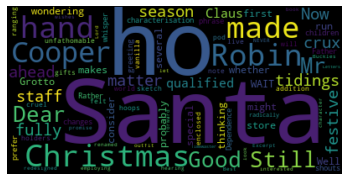

In [74]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [75]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [76]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [77]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [78]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

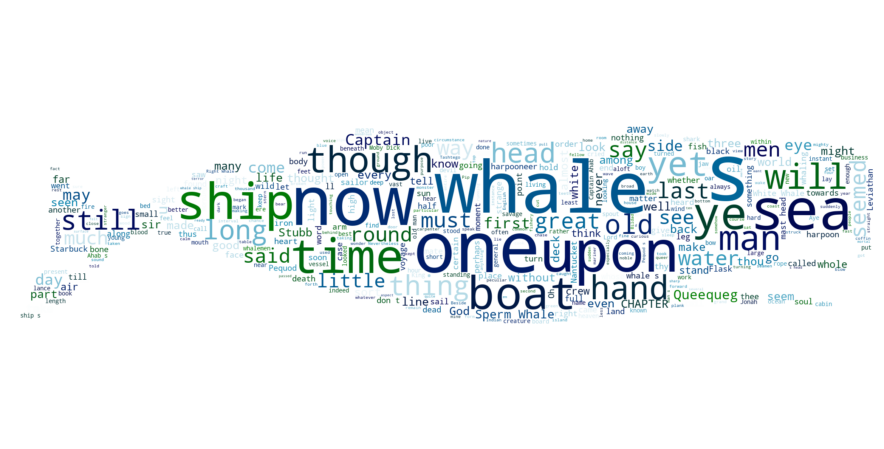

In [79]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new('RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box = icon)
rgb_array = np.array(image_mask) # converts image object to array

word_cloud = WordCloud(mask=rgb_array,background_color='white',max_words=400,colormap='ocean')
word_cloud.generate(novel_as_string)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [80]:
rgb_array.shape

(1024, 2048, 3)

In [81]:
rgb_array[1023,2047]

array([255, 255, 255], dtype=uint8)

In [82]:
rgb_array[500,1000]

array([0, 0, 0], dtype=uint8)

In [83]:
#Challenge: Use skull image for wordcloud of shakespeare's play hamlet
hamlet = nltk.corpus.shakespeare.words('hamlet.xml')
hamlet_list = [''.join(word) for word in hamlet]
hamlet_as_string = ' '.join(hamlet_list)

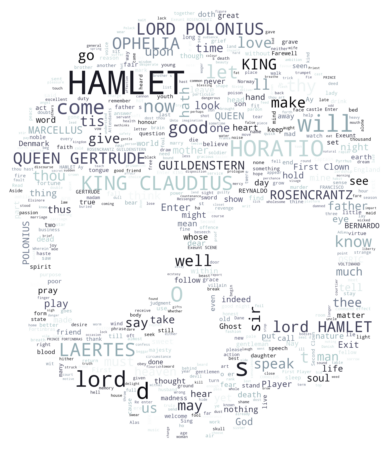

In [84]:
skull_icon = Image.open(SKULL_FILE)
simage_mask = Image.new('RGB',size=skull_icon.size,color=(255,255,255))
simage_mask.paste(skull_icon,box = skull_icon)
srgb_array = np.array(simage_mask) # converts image object to array

sword_cloud = WordCloud(mask=srgb_array,background_color='white',max_words=600,colormap='bone')
sword_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16,8])
plt.imshow(sword_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Cloud of Ham and spam messages

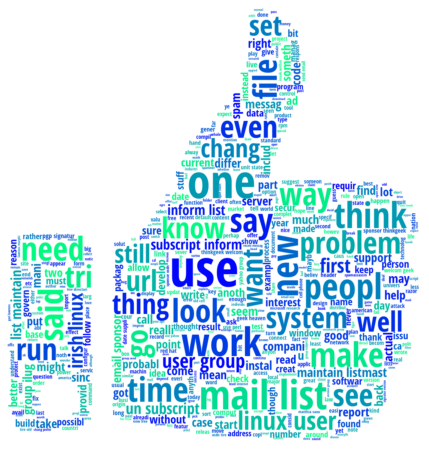

In [85]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new('RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box = icon)
rgb_array = np.array(image_mask) # converts image object to array

#Generate string
ham_str = ' '.join(flat_list_ham)

#output due to stemmed word
word_cloud = WordCloud(mask=rgb_array,background_color='white',max_words=500,colormap='winter',font_path=FONT_BOLD)
word_cloud.generate(ham_str)


plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()





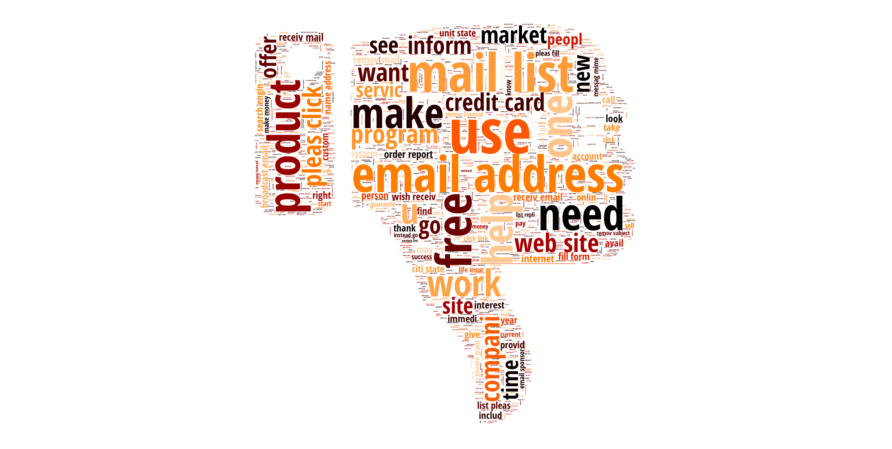

In [86]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new('RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box = icon)
rgb_array = np.array(image_mask) # converts image object to array

#Generate string
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array,background_color='white',max_words=2000,colormap='gist_heat',font_path=FONT_BOLD)
word_cloud.generate(spam_str)


plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()





# Generate Vocabulary and Dictionary

In [87]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\BHANU\anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [88]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('No. of unique words',unique_words.shape[0])
unique_words.head()

No. of unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [93]:
frequent_words = unique_words[:VOCAB_SIZE]
print('Most Common Words: \n',frequent_words[:10])

Most Common Words: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


## Create a Vocabulary DataFrame eith a WORD_ID

In [96]:
word_ids = list(range(0,VOCAB_SIZE))
vocab = pd.DataFrame({"VOCAB_WORD":frequent_words.index.values},index= word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the vocabulary as csv file

In [98]:
vocab.to_csv(WORD_ID_FILE,index_label=vocab.index.name,header=vocab.VOCAB_WORD.name)


## Exercise: Checking if the word is Part of the vocabulary

In [111]:
any(vocab.VOCAB_WORD == 'machine') #inefficient

False

In [110]:
# 'machine' in set(vocab.VOCAB_WORD)
# 'learn' in set(vocab.VOCAB_WORD)
# 'fun' in set(vocab.VOCAB_WORD)
# 'data' in set(vocab.VOCAB_WORD)
# 'science' in set(vocab.VOCAB_WORD)
# 'app' in set(vocab.VOCAB_WORD)
'brewery' in set(vocab.VOCAB_WORD)

False

## Exercise: Find the email with most number of words

In [114]:
# Python list comprehension
clean_email_length = [len(sublist) for sublist in stemmed_nested_list]
print('No. of stemmed words in the longest mail',max(clean_email_length))

No. of stemmed words in the longest mail 7671


In [117]:
print('Email position in the list (and the dataframe)',np.argmax(clean_email_length))

Email position in the list (and the dataframe) 5775


In [120]:
stemmed_nested_list[np.argmax(clean_email_length)][:5]

['yahoo', 'group', 'sponsor', 'dvd', 'free']

In [121]:
data.at[np.argmax(clean_email_length),'MESSAGE']

: Archive format has changed. Make sure you\n        synchronize your replicas before upgrading, to avoid spurious\n        conflicts. The first sync after upgrading will be slow.\n      * New/improved functionality:\n           + A new preference -sortbysize controls the order in which\n             changes are displayed to the user: when it is set to true,\n             the smallest changed files are displayed first. (The default\n             setting is false.)\n           + A new preference -sortnewfirst causes newly created files to\n             be listed before other updates in the user interface.\n           + We now allow the ssh protocol to specify a port.\n           + Incompatible change: The unison: protocol is deprecated, and\n             we added file: and socket:. You may have to modify your\n             profiles in the .unison directory. If a replica is specified\n             without an explicit protocol, we now assume it refers to a\n             file. (Previously 

# Generate Features and Sparse Matrix
## Creating a dataframe with one word per column

In [123]:
type(stemmed_nested_list)

pandas.core.series.Series

In [126]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.to_list())

In [128]:
word_columns_df.shape

(5796, 7671)

### Splitting the data into a taraining and Testing Dataset

In [131]:
X_train,X_test,y_train,y_test = train_test_split(word_columns_df,data.CATEGORY,test_size=0.3,random_state=42)

In [133]:
print('No of training samples ',X_train.shape[0])
print('Fraction of training set ',X_train.shape[0]/word_columns_df.shape[0])


No of training samples  4057
Fraction of training set  0.6999654934437544


In [139]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [138]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

### Create a sparse matrix to training data

In [142]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [143]:
word_index.get_loc('thu')

393

In [147]:
def make_sparse_matrix(df,indexed_words,labels):
    """
    Returns sparse matrix as DataFrames

    df: A Dataframe with words in columns with a document id as an index(X_train or X_test)
    indexed_words: index of words ordered by order id
    labels: Category as a series(y_train or y_test)
    """

    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []

    for i in range(nr_rows):
        for j in range(nr_cols):

            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]

                item = {'LABEL':category,'DOC_ID':doc_id,'OCCURENCE':1,'WORD_ID':word_id}

                dict_list.append(item)

    return pd.DataFrame(dict_list)

In [148]:
%%time
sparse_train_df = make_sparse_matrix(X_train,word_index,y_train)

Wall time: 5min 57s


In [150]:
sparse_train_df.shape

(429252, 4)

In [151]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
429247,1,860,1,47
429248,1,860,1,1429
429249,1,860,1,26
429250,1,860,1,21
429251,1,860,1,126


### Combine Occurences with the pandas groupby() Method

In [163]:
train_grouped = sparse_train_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [158]:
vocab.at[3,'VOCAB_WORD']

'email'

In [164]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [165]:

train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
258359,5795,2038,0,2
258360,5795,2040,0,1
258361,5795,2266,0,1
258362,5795,2329,0,1
258363,5795,2355,0,1


In [166]:
vocab.at[2038,'VOCAB_WORD']

'swap'

In [167]:
data.MESSAGE[5795]

"Hi there,\n \n Now this is probably of no use to you whatsoever, but...\n \n Not a deb-head, but I also have a problem regards NVidia. I've two machines,\n pretty much the same hardware. \n athlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\n both use the same driver module. \n \n Both have same kernel version albeit it compiled for their particular\n hardware.\n \n One works perfectly, the other fails to load. When I check with lsmod, I can\n see the NVdriver is loaded, but not used ;--(\n Thus when I startx, it bombs out. \n \n IU still have X with the default nv driver and crappy accelleration -->\n 650fps with glxgears [should be over 2000fps]\n Its not a hardware issue with the cards as I swapped them over and get the\n same symptoms. \n \n I reckon my mobo is cack, I've tried swapping slots around, reserving\n resources etc all to no avail. \n Should there be an interrupt for the nv card? I haven't checked the other\n box yet.\n \n Regards,\n CW\n \n ------

In [168]:
train_grouped.shape

(258364, 4)

### Save training Data as .txt file

In [170]:
np.savetxt(TRAINING_DATA_FILE,train_grouped,fmt="%d")

In [171]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [173]:
# Challenge do same for test data
sparse_test_df = make_sparse_matrix(X_test,word_index,y_test)


In [175]:
test_grouped = sparse_test_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
test_grouped = test_grouped.reset_index()
np.savetxt(TEST_DATA_FILE,test_grouped,fmt="%d")

## Pre-Processing Subtleties and Checking the Understanding
Challenge: We started with 5796 emails. We split it into 4057 emails for training and 1739 emails for testing.
How many individual emails were included in testing.txt file? Count the number in the test_grouped DataFrame. After splitting and shifting our data, how many emails were included in the X_test_dataframe?Is the number same? If not which emails were excluded and why? Compare DOC_ID values to findout

In [176]:
train_doc_ids= set(train_grouped.DOC_ID)
test_doc_ids= set(test_grouped.DOC_ID)

In [179]:
len(test_doc_ids)

1724

In [180]:
len(X_test)

1739

In [183]:
set(X_test.index.values) - test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [188]:
data.MESSAGE[134]

'------=_NextPart_000_00E8_85C13B1D.B7243B86\n Content-Type: text/html; charset="iso-8859-1"\n Content-Transfer-Encoding: base64\n \n \n PGh0bWw+DQoNCjxib2R5IGJnY29sb3I9IiNGRkZGRkYiIHRleHQ9IiMwMDAw\n MDAiPiANCjxwIGFsaWduPSJjZW50ZXIiPjxhIGhyZWY9Imh0dHA6Ly93d3cu\n ZGlyZWN0d2Vic3RvcmUuY29tL3RveXMvaW5kZXguaHRtbCI+PGltZyBzcmM9\n Imh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL21waWMuanBnIiB3aWR0\n aD0iNTAwIiBoZWlnaHQ9IjMzOSIgYm9yZGVyPSIwIj48L2E+PGJyPiANCjxm\n b250IHNpemU9IjMiIGZhY2U9IkFyaWFsLCBIZWx2ZXRpY2EsIHNhbnMtc2Vy\n aWYiPjxhIGhyZWY9Imh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL3Rv\n eXMvaW5kZXguaHRtbCI+PGI+RU5URVIgDQpOT1cgaWYgeW91IGFyZSAxOCBh\n bmQgb3ZlcjwvYj48L2E+PC9mb250PjwvcD4gDQo8cCBhbGlnbj0iY2VudGVy\n Ij48Zm9udCBmYWNlPSJBcmlhbCwgSGVsdmV0aWNhLCBzYW5zLXNlcmlmIiBz\n aXplPSI0IiBjb2xvcj0iI0ZGMDAwMCI+PGI+U1BFQ0lBTCANCk9GRkVSPGJy\n PiANCjxmb250IHNpemU9IjUiPjMwIERheXMgPGk+RlJFRSBhY2Nlc3M8L2k+\n IDwvZm9udD48YnI+IA0KdG8gdGhlIGxhcmdlc3QgQWR1bHRzaXRlIG9uIHRo\n ZSB3ZWIuPGJyPiANCjwvYj4gPGZvbnQgc2l6ZT0iMiI+

In [192]:
data.loc[765]

MESSAGE      <html><body><IMG SRC='http://master2.free4all....
CATEGORY                                                     1
FILE_NAME               00266.12e00174bc1346952a8ba2c430e48bf6
Name: 765, dtype: object

In [193]:
clean_msg_no_html(data.at[765,'MESSAGE'])

[]

In [194]:
clean_message(data.at[765,'MESSAGE'])

['html', 'bodi', 'img', 'center', 'img']